# 01_run_simulations


## Imports, define model

In [1]:
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size']=16
import numpy as np
from matplotlib.colors import LogNorm
import csv

from scipy.optimize import curve_fit
import scipy.special as special
from scipy import integrate

path = os.getcwd()
basepath = os.path.dirname(path)
datapath = basepath+'/data'
figpath = basepath+'/figures'
srcpath =  basepath +'/src'

if srcpath not in sys.path:
    sys.path.append(srcpath)

import models
from pdeSim import PoissonFlow2D    

## Parameters for simulation

### Parameters

half_width i: half width in x lattice spacing for the heater  
material str: substrate material, only certain allowed  
nx, ny i: number of grid points in x,y  
save_file bool: save the figures?  

In [2]:
half_width = 4
material = 'silicon_dioxide'
nx = 401
ny = 201

#Save details
save_file = True

#Import the model
k_in,c_in,rho_in,Q_in,v_in,x,y,dx,dy,nx,ny = models.single_wire(
    material = material,half_width=half_width,nx=nx,ny=ny)

## We need to import the thermal parameters to use in the analytic models

In [3]:
##Builds up the dictionaries of thermal parameters

k = {}
c = {}
rho = {}

filename = basepath+"/src/thermal_properties.csv"

with open(filename,'r') as f:
    csvreader = csv.DictReader(f)
    for row in csvreader:
        k[row['material']]= float(row['thermal_conductivity'])
        c[row['material']]= float(row['specific_heat'])
        rho[row['material']]= float(row['density'])
        

## Plot heat sources/sinks


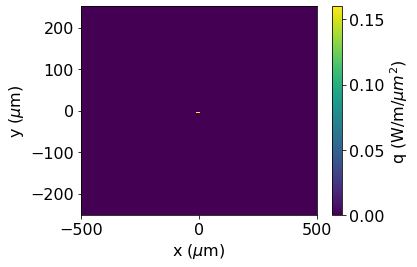

In [4]:
fig,ax=plt.subplots(1,1,figsize=[6,4])

myplot = ax.pcolor(x*1e6,y*1e6,Q_in.T/dx/dy/1e12,shading='auto')

ax.set_xlabel('x ($\mu$m)')
ax.set_ylabel('y ($\mu$m)')
cbar = fig.colorbar(myplot)
cbar.set_label('q (W/m/$\mu m^2$)')
fig.tight_layout()

if save_file==True:
    fig.savefig(figpath+ '/'+material+'_q.png',dpi=300)

## Plot thermal conductivities

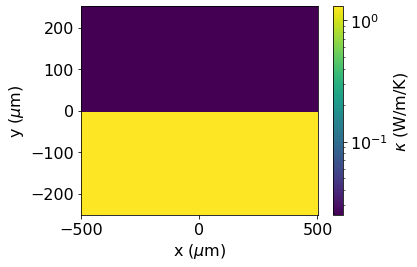

In [5]:
fig,ax=plt.subplots(1,1,figsize=[6,4])

myplot = ax.pcolor(x[::1]*1e6,y[::1]*1e6,k_in.T[::1,::1],shading='auto',
                   norm=LogNorm(vmin=k_in.min(),vmax=k_in.max()))

ax.set_xlabel('x ($\mu$m)')
ax.set_ylabel('y ($\mu$m)')
cbar = fig.colorbar(myplot)
cbar.set_label('$\kappa$ (W/m/K)')

fig.tight_layout()
if save_file==True:
    fig.savefig(figpath+'/'+material+'_kappa.png',dpi=300)

## Solve the PDE at different excitation frequencies
### Parameters
min_freq int: min frequency, x where 10^x is the frequency  
max_freq int: max frequency, x where 10^x is the frequency  
freq_steps int: freq steps on a log scale  

In [6]:
min_freq = 0
max_freq = 3
freq_steps = 10

freqs = np.logspace(min_freq,max_freq,freq_steps)

out = []

k_in,c_in,rho_in,Q_in,v_in,x,y,dx,dy,nx,ny = models.single_wire(
    material=material,half_width = half_width, nx = nx, ny = ny)

for freq in freqs:
    pf = PoissonFlow2D(Q_in,k_in,v_in,dx,dy,c_in,rho_in,freq)
    out.append(pf.sparseSolve()) 

## Plots the real and imag parts of temperature

### Parameters

i int : set the item in the frequency list for plotting the real and imag temperature. 

Plot frequency is 1000 Hz
thermal wavelength is 6.25e-06


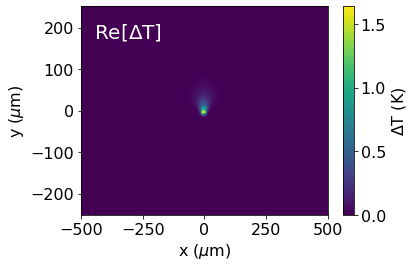

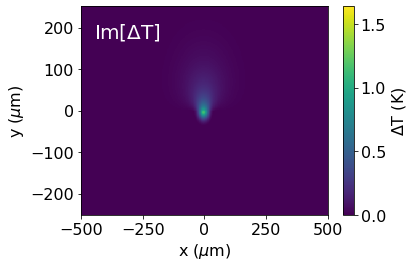

In [7]:
freq_index = 9 # the frequency point at which to plot the temperature

print('Plot frequency is {:0.0f} Hz'.format(freqs[freq_index]))

wavelength = np.sqrt(k[material]/c[material]/rho[material]/2/2/np.pi/freqs[freq_index])
print('thermal wavelength is {:0.2e}'.format(wavelength))

fig,ax = plt.subplots(1,1,figsize=[6,4])
graph = ax.pcolor(x*1e6,y*1e6,out[freq_index].real.T,shading='auto',
                  vmin=0,vmax=np.max(out[freq_index].real))

ax.set_xlabel('x ($\mu$m)')
ax.set_ylabel('y ($\mu$m)')
cbar = fig.colorbar(graph)
cbar.set_label('$\Delta$T (K)')
ax.text(-450,175,'Re[$\Delta$T]',color='w',size=20)

fig.tight_layout()
if save_file==True:
    fig.savefig(figpath+'/'+material+'_real_{:0.0f}_Hz.png'.format(freqs[freq_index])
                ,dpi=300)

fig,ax = plt.subplots(1,1,figsize=[6,4])
graph = ax.pcolor(x*1e6,y*1e6,out[freq_index].imag.T,shading='auto',
                  vmin=0,vmax=np.max(out[freq_index].real),facecolor='w')

ax.set_xlabel('x ($\mu$m)')
ax.set_ylabel('y ($\mu$m)')
cbar = fig.colorbar(graph)
cbar.set_label('$\Delta$T (K)')
ax.text(-450,175,'Im[$\Delta$T]',color='w',size=20)

fig.tight_layout()
if save_file==True:
    fig.savefig(figpath+'/'+material+'_imag_{:0.0f}_Hz.png'.format(freqs[freq_index]),
                dpi=300,facecolor='w')

## The temperatures

The real and imaginary parts of the average temperature over the heater.

In [8]:
Ts_real = []
Ts_imag = []

for i,freq in enumerate(freqs):
    T_real = np.average(out[i].real[(nx//2-half_width):(nx//2+half_width),ny//2-1:ny//2])
    Ts_real.append(T_real)
    T_imag = np.average(out[i].imag[(nx//2-half_width):(nx//2+half_width),ny//2-1:ny//2])
    Ts_imag.append(T_imag)

## Analytic solution 1
For an infinitely narrow heater over a semi-infinite half-volume. Cahill equation 1 - from Carslaw and Jaeger.

In [9]:
P = np.sum(Q_in)# power per unit length

kappa = k[material]
print('Thermal conductivity used in simulation = {} W/m/K'.format(kappa))
D = k[material]/c[material]/rho[material]


r = 1e-6 #Temperature at this distance from the heater
q = np.sqrt(2j*2*np.pi*freqs/D)
y_vals = P/(kappa*np.pi)*special.kv(0,q*r)

Thermal conductivity used in simulation = 1.3 W/m/K


## Analytic solution 2
Integrates the Carslaw and Jaeger expression over a heater of finite width. Cahill equation 8. 

In [10]:
width = half_width*2*dx
integral = []
for i in range(0,len(freqs)):
    invexp = lambda k: P/kappa/np.pi*np.sin(width/2*k)**2/(width/2*k)**2/np.sqrt(k**2+q[i].real**2)
    I=integrate.quad(invexp,0,1000000)
    integral.append(I[0])
    

## Plots the analytic and simulated solutions

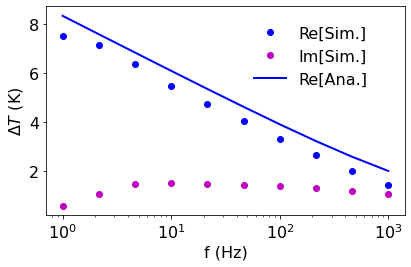

In [11]:
fig,ax=plt.subplots(1,1,figsize=[6,4])
ax.semilogx(freqs,Ts_real,'.',markersize=12,color='b',label='Re[Sim.]')
ax.semilogx(freqs,Ts_imag,'.',markersize=12,color='m',label='Im[Sim.]')    

ax.semilogx(freqs,integral,linewidth=2,label='Re[Ana.]',color='b')

ax.set_ylabel('$\Delta T$ (K)')
ax.set_xlabel('f (Hz)')
fig.legend(frameon = False,loc = [0.6,0.65])

fig.tight_layout()
if save_file==True:
    fig.savefig(figpath+'/'+material+'_ana_sim.png',dpi=300)

## Figure out thermal conductivity

frequencies for fit [  1.           2.15443469   4.64158883  10.          21.5443469
  46.41588834 100.        ]
Fitted thermal conductivity = 1.341 W/m/K


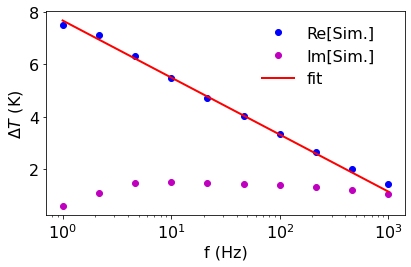

In [15]:
def log_fit(x,a,b):
    return a*np.log(x)+b

print('frequencies for fit',freqs[:7])

popt,pcov = curve_fit(log_fit,freqs[:7],Ts_real[:7])

print('Fitted thermal conductivity = {:0.3f} W/m/K'.format(-P/np.pi/popt[0]/2))

fig,ax=plt.subplots(1,1,figsize=[6,4])
ax.semilogx(freqs,Ts_real,'.',markersize=12,color='b',label='Re[Sim.]')
ax.semilogx(freqs,Ts_imag,'.',markersize=12,color='m',label='Im[Sim.]')    

ax.semilogx(freqs,log_fit(np.array(freqs),*popt), linewidth = 2, alpha = 1, color='r',label = 'fit')

ax.set_ylabel('$\Delta T$ (K)')
ax.set_xlabel('f (Hz)')
fig.legend(frameon = False,loc = [0.62,0.65])

fig.tight_layout()
if save_file==True:
    fig.savefig(figpath+'/'+material+'_sim_fit.png',dpi=300)